# Regular Genomics Project **RNA Localisation**


---

**Problem definition**:

TODO


### **1.** Data Preparation

Firstly, we import several necessary packages and load in our data:

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Initializing test/train split


colab = False  #### Set colab flag ####

if colab:
    np.random.seed(3)
    url = 'https://www.dropbox.com/s/hv4uau8q4wwg00k/final_data.csv?dl=1'
    data_org = pd.read_csv(url)
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index)
else:
    np.random.seed(3)
    data_org = pd.read_csv('~/Downloads/final_data.csv')
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index) # TODO: note: we also have to preprocess the test set similary
    # TODO: colab

data_org

,ERM,KDEL,LMA,MITO,NES,NIK,NLS,NUCP,OMM,gene_id,gene_biotype,seq,struct,m6A_5UTR,m6A_CDS,m6A_3UTR
0,57.045409,35.456782,22.008215,12.355106,22.789983,24.241731,16.970436,29.348389,54.916891,ENSG00000000003,protein_coding,ACCTTGTATTAGGTATTTATTTCCACAAAAGTTTGATGCTTACAAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.914814,0.244517,ENSG00000000005,protein_coding,TGTGCACAGAAGTTATATACATATATGGGTATATCTATGTAACAAA...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
2,17.449430,34.151539,29.338431,22.237585,24.682767,43.612551,38.683963,35.678476,25.348560,ENSG00000000419,protein_coding,TACTTTATGCAAAAAAAAATATACATTTATTTATAGGTCTCAATAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
3,3.830180,2.576734,5.737850,0.761343,2.786808,2.784356,3.382682,2.463676,2.819269,ENSG00000000457,protein_coding,TGACTTTCAAACCATTTTAATATTTCAAATATTCCAGAACAATCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,9,5
4,13.132915,8.782925,10.061390,3.012459,8.821250,6.721117,10.827253,8.005113,6.849962,ENSG00000000460,protein_coding,AACCCGCTCGGGTCCCCTTCCACACTGTGGAAGCTTTGTTCTTTCG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13805,0.000000,0.000000,0.506809,0.075893,0.050764,0.000000,0.056586,0.000000,0.000000,ENSG00000281883,protein_coding,GGGAAGAAAGGAGCCTGACTCTTATGATGGAATAACCACAAATCAG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,2,1
13806,0.105452,0.087130,0.171187,0.016101,0.079057,0.669947,0.171672,0.000000,0.254546,ENSG00000282034,protein_coding,GTGTCGGACGGCATGACAGGCAGCAATCCTGTGTCCCCTGCCTCAT...,"[0.37599998712539673, 0.0, 0.07500000298023224...",0,66,4
13807,0.037093,0.444844,0.425368,0.254467,0.323794,1.803249,1.435483,0.249590,0.483645,ENSG00000282827,protein_coding,ATGGCGGGGACCTCCGCGCCAGGCAGCAAGAGGCGGAGCGAGCCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
13808,0.000000,0.519421,2.119115,0.360450,0.887939,0.345021,1.274465,0.741954,0.460649,ENSG00000282936,protein_coding,CTACTGGAACGCCCCCCTCAATCTAGCCTCCCCCACATAACTCTCT...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2


### **2** |  Initializations

We use as baseline model the [RNATracker](https://github.com/HarveyYan/RNATracker/blob/master/Models/cnn_bilstm_attention.py) model and a CNN model.


In [3]:
max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()

# DataLoader
param_dataLoader_train = {
    'padding_length': max_seq_len,
    "batch_size": 32,
    "shuffle": True
    }

param_dataLoader_valid = {
    'padding_length': max_seq_len,
    "batch_size": 32,
    "shuffle": True
    }

params_model = {'conv': [{'filters': 64, 'kernel_size': 9, 'activation': 'relu', 'input_shape': (max_seq_len, 4)}],
                'dense': [{'units': 9, 'activation': 'softmax'}],
                'pooling': [{'pool_size': 34518, 'strides': 1}]}

params_train = {'epochs': 10, 'use_multiprocessing': True}

In [4]:
# training, only need for the model initialization to change in general
from models import func_CNN as CNN

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)

model = CNN(architecure='cpfe',
            input_size=(max_seq_len, 4),
            params_model=params_model)     

model.model.summary()

2023-06-24 01:27:55.651292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34526, 4)]        0         
                                                                 
 conv1d (Conv1D)             (None, 34518, 64)         2368      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 9)                 585       
                                                                 
Total params: 2,953
Trainable params: 2,953
Non-trainable params: 0
___________________________________________________________

In [5]:
history = model.fit(train_data=train_data, params_dataLoader=param_dataLoader_train, params_train=params_train)


Epoch 1/10


2023-06-24 01:28:02.146124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


311/311 [==============================] - 77s 229ms/step - loss: 2.1728 - accuracy: 0.1555
Epoch 2/10
311/311 [==============================] - 74s 223ms/step - loss: 2.1676 - accuracy: 0.1830
Epoch 3/10
311/311 [==============================] - 75s 227ms/step - loss: 2.1654 - accuracy: 0.1941
Epoch 4/10
311/311 [==============================] - 73s 221ms/step - loss: 2.1644 - accuracy: 0.2062
Epoch 5/10
311/311 [==============================] - 73s 221ms/step - loss: 2.1634 - accuracy: 0.2116
Epoch 6/10
311/311 [==============================] - 76s 227ms/step - loss: 2.1630 - accuracy: 0.2124
Epoch 7/10
311/311 [==============================] - 73s 220ms/step - loss: 2.1625 - accuracy: 0.2135
Epoch 8/10
311/311 [==============================] - 73s 221ms/step - loss: 2.1620 - accuracy: 0.2187
Epoch 9/10
311/311 [==============================] - 73s 221ms/step - loss: 2.1617 - accuracy: 0.2169
Epoch 10/10
311/311 [==============================] - 73s 220ms/step - loss: 2.1613

In [6]:
results = model.evaluate(eval_data=valid_data, params_dataLoader=param_dataLoader_valid)
results = dict(zip(model.model.metrics_names, results))

VALIDATION_ACCURACY.append(results['accuracy'])
VALIDATION_LOSS.append(results['loss'])

2023-06-24 01:41:10.453170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


78/78 [==============================] - 6s 78ms/step - loss: 2.1681 - accuracy: 0.1991


In [7]:
model.predict(valid_data, params_dataLoader=param_dataLoader_valid)

 1/78 [..............................] - ETA: 11s

2023-06-24 01:41:17.437854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


78/78 [==============================] - 6s 77ms/step


array([[0.1448117 , 0.09565755, 0.11976136, ..., 0.11977547, 0.1099736 ,
        0.12497236],
       [0.12483083, 0.09812329, 0.14572921, ..., 0.12288329, 0.12328696,
        0.11558953],
       [0.11101359, 0.12749611, 0.14039908, ..., 0.14050837, 0.12611333,
        0.09401712],
       ...,
       [0.11757755, 0.11329851, 0.13485661, ..., 0.12781405, 0.11597073,
        0.09540898],
       [0.07521828, 0.14815407, 0.11011802, ..., 0.13591173, 0.15026306,
        0.1090359 ],
       [0.08187462, 0.15230897, 0.11335406, ..., 0.14444579, 0.15429641,
        0.10313325]], dtype=float32)

IndexError: list index out of range

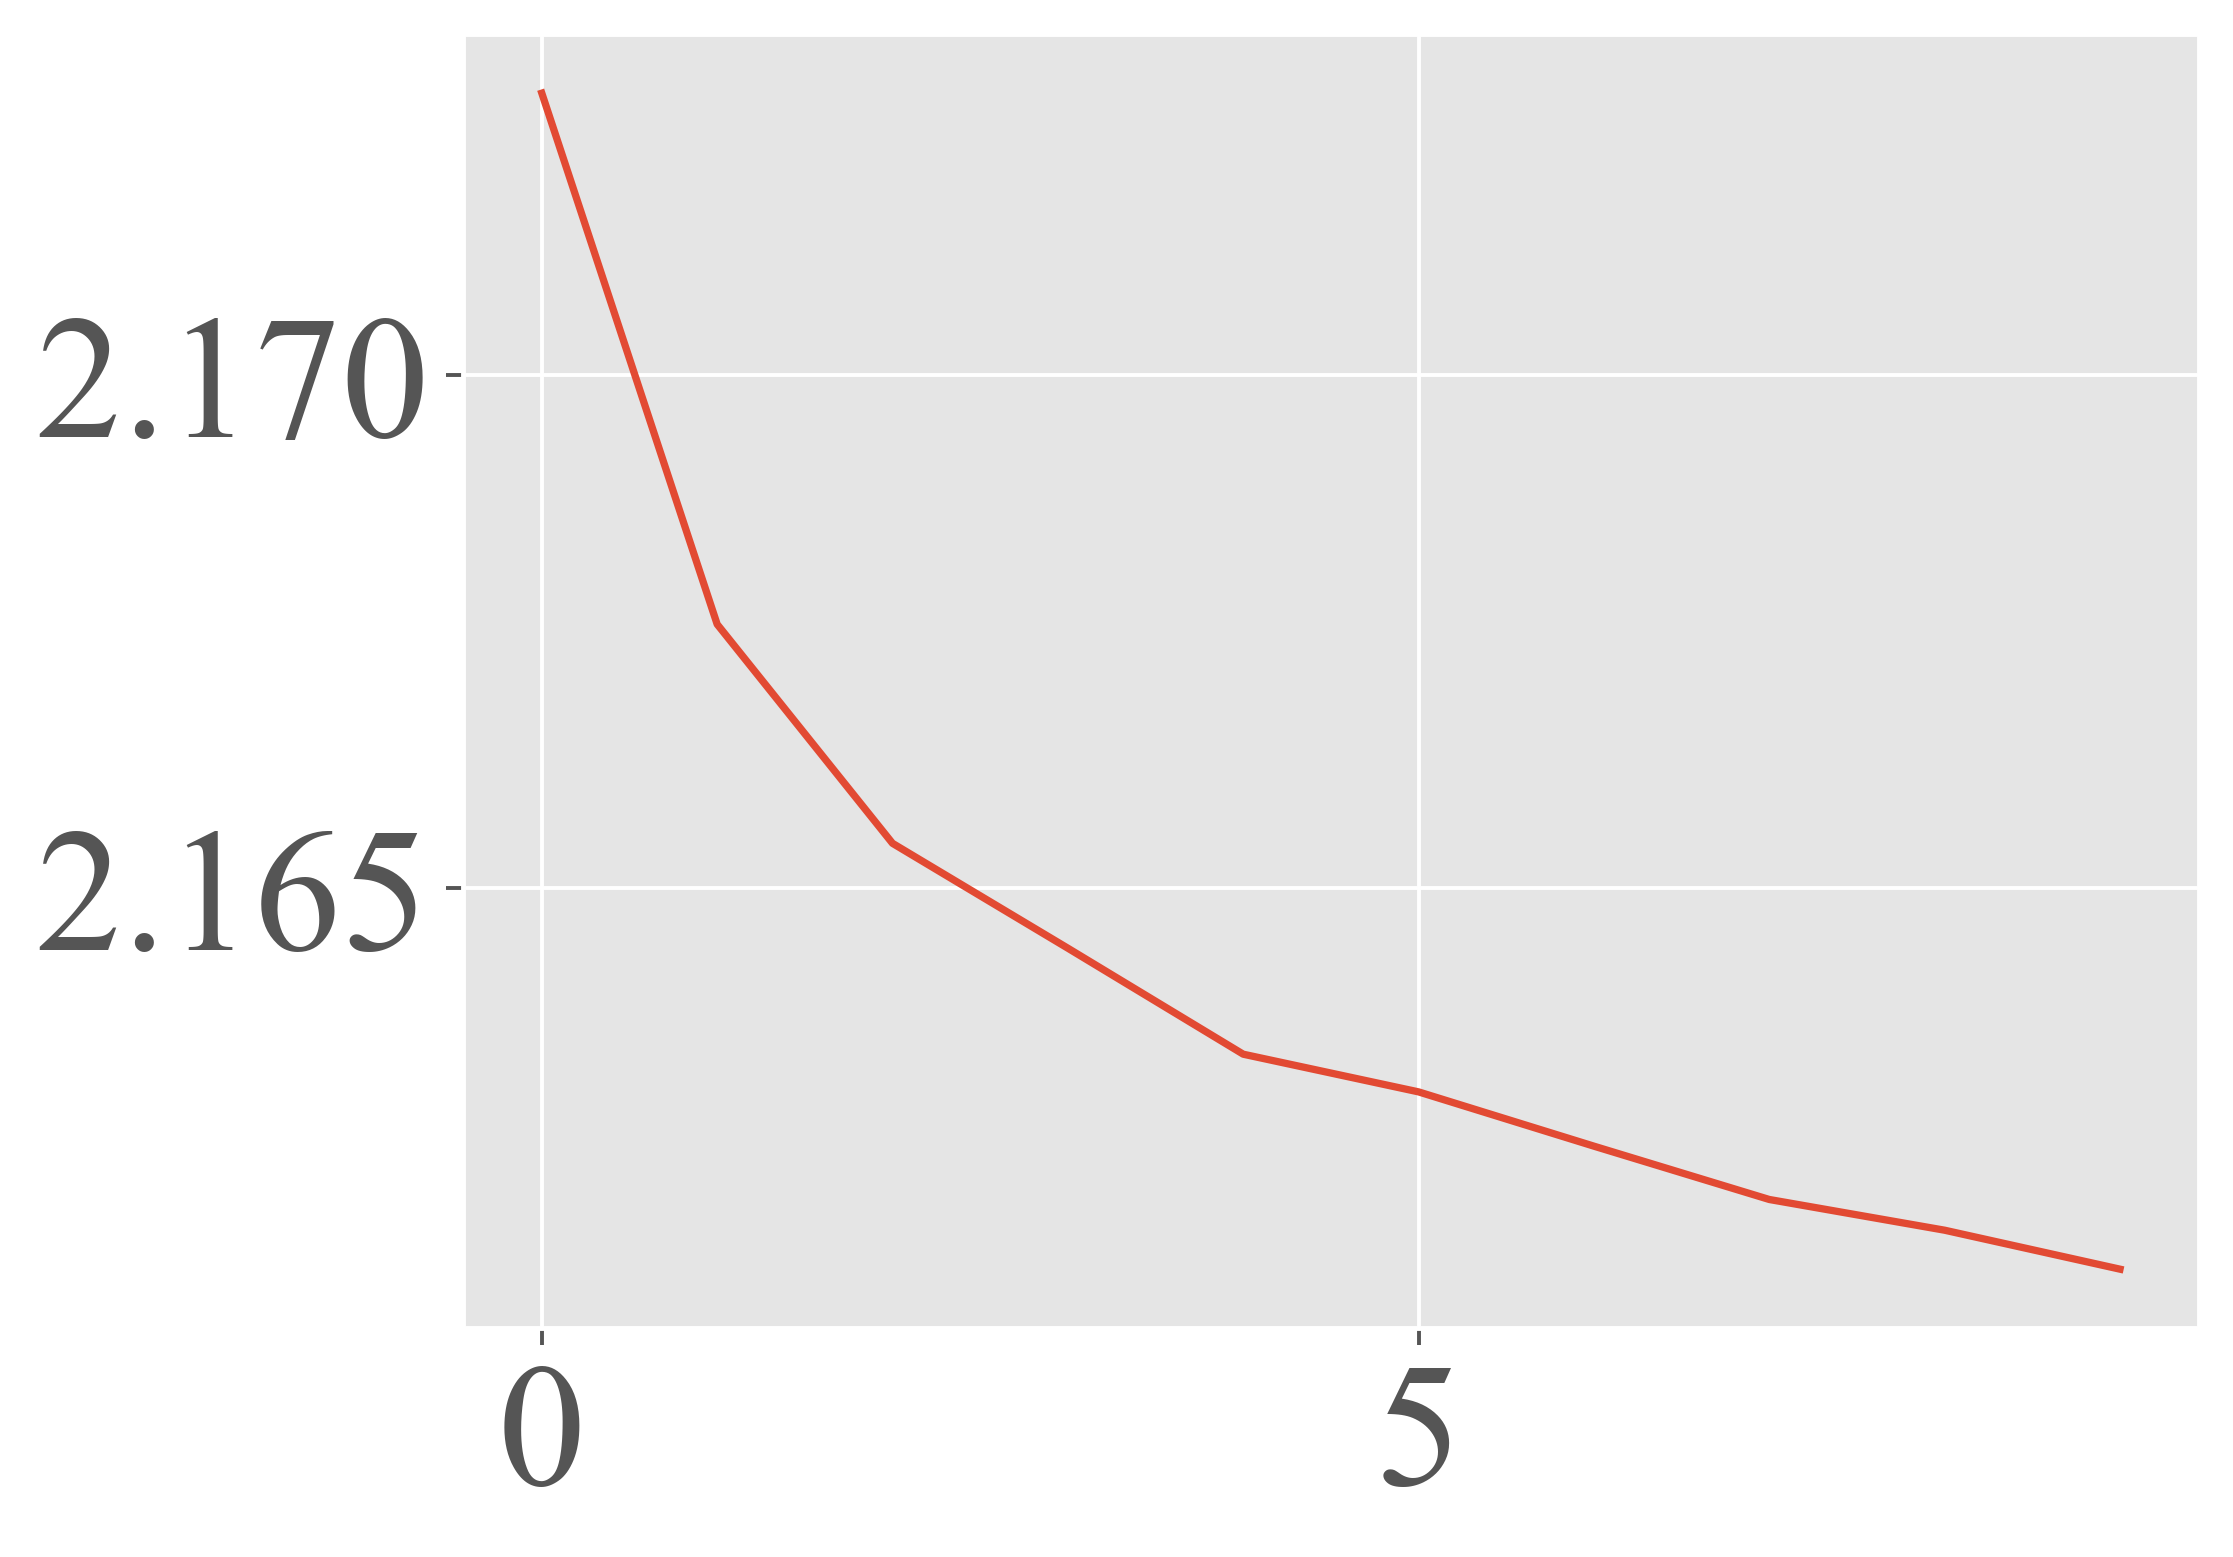

In [8]:
from models.utils import plot_line_graph

plt_data = [history.history['loss']]
plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['test', 'val'])

plt_data = [history.history['accuracy']]
plot_line_graph(plt_data, "Accuracy Graph", 'accuracy', 'epoch', ['test', 'val'])

In [9]:
plt_data

[[2.1727511882781982,
  2.167574405670166,
  2.1654391288757324,
  2.164416790008545,
  2.163383722305298,
  2.1630163192749023,
  2.162487268447876,
  2.1619675159454346,
  2.161668062210083,
  2.161288261413574]]

In [10]:
import keras
keras.backend.clear_session()